# Homework 4 (WIP)

1. Implement a solver for the shallow water equations,
$$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$
where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential.
The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.
* Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.
* The total energy in the system is kinetic plus potential energy
$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$
Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.
* Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL?  Does it depend on your choice of limiter in slope reconstruction?

In [1]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

%run hw_support.py

## Solver Setup

Thinking of the shallow water equations as
$$ U_t + f(U)_x = 0 $$
we have the following, with $h$ and $hu$ conserved.
\begin{align} U &= \begin{bmatrix} h \\ hu \end{bmatrix} & f(U) &= \begin{bmatrix} hu \\ hu^2 + \frac{g}{2} h^2 \end{bmatrix} \end{align}
To keep all the values in terms of the conserved variables, we'll use $hu^2 = \frac{(hu)^2}{h}$. The flux Jacobian of $f$ is
$$ f'(U) = \begin{bmatrix} 0 & 1 \\ -u^2 + gh & 2u \end{bmatrix}. $$
Now we can compute the eigenvalues of $f'(U)$:
\begin{align} 
0 &= \left|f' - \lambda I \right|\\
0 &= \begin{vmatrix} 0 - \lambda & 1 \\ -u^2 + gh & 2u - \lambda\end{vmatrix}\\
0 &= - \lambda (2u - \lambda) - u^2 + gh\\
0 &= \lambda^2 + (-2u)\lambda + (u^2 - gh)\\
\end{align} 
Solving with the quadratic formula, we get the following.
$$\lambda = u \pm \sqrt{gh}$$

An HLL solver for this problem now follows, adapted from the solver for the isentropic gas equation from lecture.

In [2]:
def flux_shallow_water(U, g):
    """
    Returns the flux for the shallow water equations, evaluated at U:
    f(U) = [ hu               ]
           [ h*u^2 + (g/2)*h^2]
    
    Parameters:
      U: a 2xn matrix with the following rows
        0: h, thickness
        1: hu, momentum
      g: gravitational potential
    
    Returns:
      the flux, f(U)
    """
    h = U[0]
    u = U[1] / h
    return numpy.array([U[1], U[1]*u + (U[0]**2)*g*0.5])

def riemann_shallow_water_hll(UL, UR, g, use_rusanov=False):
    """
    Params:
      UL: left wave state
      UR: right wave state
      g: graviatational potential
      use_rusanov: whether to use a (True) Rusanov or (False) HLL solver 
        (default: False)
    """
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
        
    sqrt_ghL = numpy.sqrt(numpy.absolute(g * UL[0]))
    sqrt_ghR = numpy.sqrt(numpy.absolute(g * UR[0]))
    
    sL = numpy.minimum(uL - sqrt_ghL, uR - sqrt_ghR)
    sR = numpy.maximum(uL + sqrt_ghL, uR + sqrt_ghR)
    
    if use_rusanov:
        sR = numpy.maximum(numpy.absolute(sR), numpy.absolute(sL))
        sL = -sR
    
    fL = flux_shallow_water(UL, sqrt_ghL)
    fR = flux_shallow_water(UR, sqrt_ghR)
    
    # TEMP: what branches are being taken?
    ssL = sum(numpy.where(sL > 0, 1, numpy.where(sR < 0, 0, 0)))
    ssR = sum(numpy.where(sL > 0, 0, numpy.where(sR < 0, 1, 0)))
    if ssL != 0 or ssR !=0:
        print("ssL", ssL, "ssR", ssR)
        
    # if sL > 0 : if supersonic moving right, sample the left state
    # elif sR < 0 : if supersonic in the other direction, sample from the right
    # else subsonic
    return numpy.where(sL > 0, fL,
                       numpy.where(sR < 0, fR, 
                                   (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))

def initial_basic(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2)),
                        0*x])

def initial_high_right(x):
    return numpy.array([1 + numpy.where(x < 0.5, 0, 2.5),
                        0*x])

## Solution Approximations

The following plots show the water thickness and velocity at a set of points in time. The solution to the shallow water equations use in the plots is calculated using an HLL solver with the following initial conditions:
\begin{align}h_0 &= \left\{\begin{matrix}
1 & x < 0.5 \\ 
3.5 & x \geq 0.5
\end{matrix}\right.
& v_0 &= \mathbf{0}
\end{align}

<IPython.core.display.Javascript object>


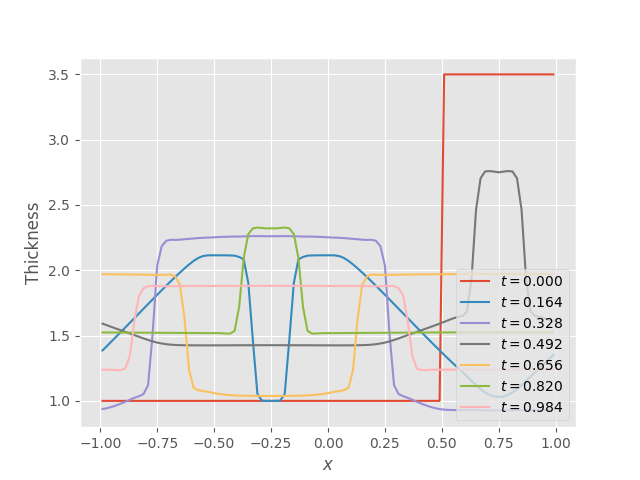

<IPython.core.display.Javascript object>


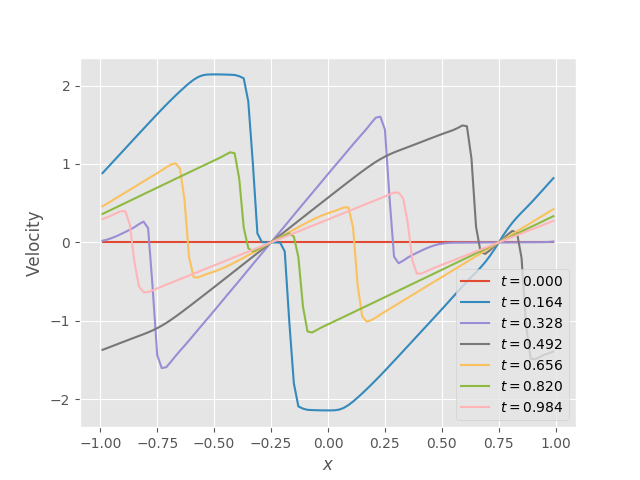

In [3]:
def plot_solution(solver, ic, args=()):
    x, hist = fvsolve2system(solver, ic, n=100, limit=limit_vl, args=args)
    
    pyplot.figure()
    for t, U in hist[::len(hist)//6]:
        pyplot.plot(x, U[0], label='$t={:.3f}$'.format(t))
    pyplot.ylabel('Thickness')
    pyplot.xlabel('$x$')
    pyplot.legend(loc='lower right');
    
    pyplot.figure()
    for t, U in hist[::len(hist)//6]:
        pyplot.plot(x, U[1]/U[0], label='$t={:.3f}$'.format(t))
    pyplot.ylabel('Velocity')
    pyplot.xlabel('$x$')
    pyplot.legend(loc='lower right')
        
plot_solution(riemann_shallow_water_hll, initial_high_right, args=(10,))

The solution in the next plots uses the same initial condition, but was calculated using a Rusanov solver.

<IPython.core.display.Javascript object>


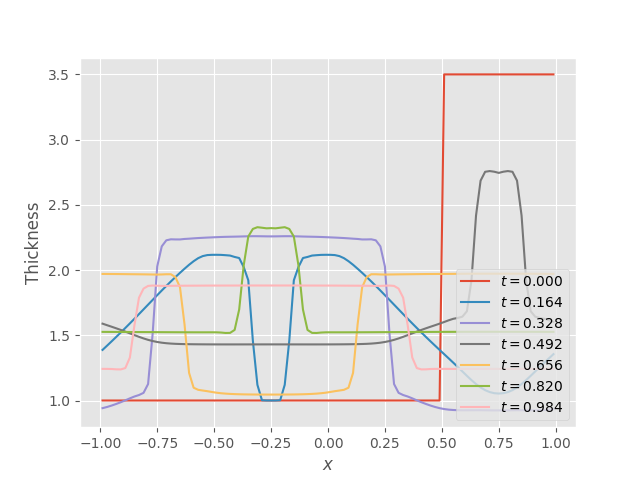

<IPython.core.display.Javascript object>


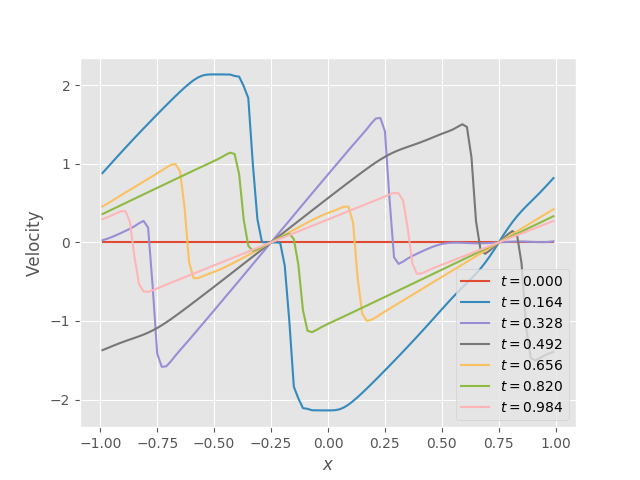

In [4]:
plot_solution(riemann_shallow_water_hll, initial_high_right, args=(10,True))

## Energy Conservation

We will now examine the energy of the system:
$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$
To calculate this value, we can take a sum of these terms (the kinetic and potential energy) over the grid elements, then divide by the number of elements. The code below does this for a solution $U$ at some time.

<IPython.core.display.Javascript object>


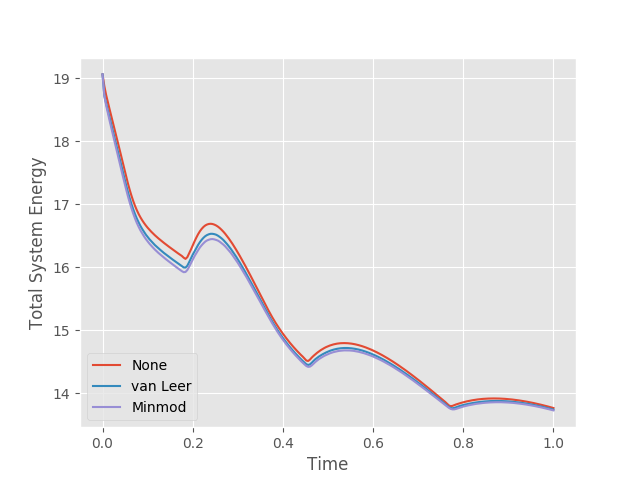

In [5]:
def total_energy(U, g):
    """
    Calculate the total energy of the system as the sum of its kinetic and 
    potential energy.
    
    Params:
      U: solution approximation at a single time value
      g: gravitational potential used in the system
      
    Returns:
      total energy of the system 
    """
    n = len(U[0])
    h = U[0]
    u = U[1] / h
    return numpy.sum(((h * u**2) + (g * h**2)) / 2) / n


def compare_energy(hists, labels):
    """
    For multiple solutions to the shallow water equations, plots the total 
    energy of the system over time for comparison.
    
    Params:
      hists: solution from fvsolve2system
      labels: list of strings to label each time, energy line
    """
    pyplot.figure()
    
    for (hist, label) in zip(hists, labels):
        energy = [total_energy(U, g) for _, U in hist]
        time = [t for t, _ in hist]
        pyplot.plot(time, energy, label=label)

    pyplot.ylabel('Total System Energy')
    pyplot.xlabel('Time')
    pyplot.legend(loc='lower left')

n = 100
g = 10

_, hist_none = fvsolve2system(riemann_shallow_water_hll, initial_high_right, 
                              n=n, limit=limit_none, args=(g,))
_, hist_vl = fvsolve2system(riemann_shallow_water_hll, initial_high_right, 
                            n=n, limit=limit_vl, args=(g,))
_, hist_minmod = fvsolve2system(riemann_shallow_water_hll, initial_high_right, 
                                n=n, limit=limit_minmod, args=(g,))
hists_limiters = [hist_none, hist_vl, hist_minmod]
labels_limiters = ['None', 'van Leer', 'Minmod']
compare_energy(hists_limiters, labels_limiters)

The plot below compares energy across time for the HLL and Rusanov solvers.

<IPython.core.display.Javascript object>


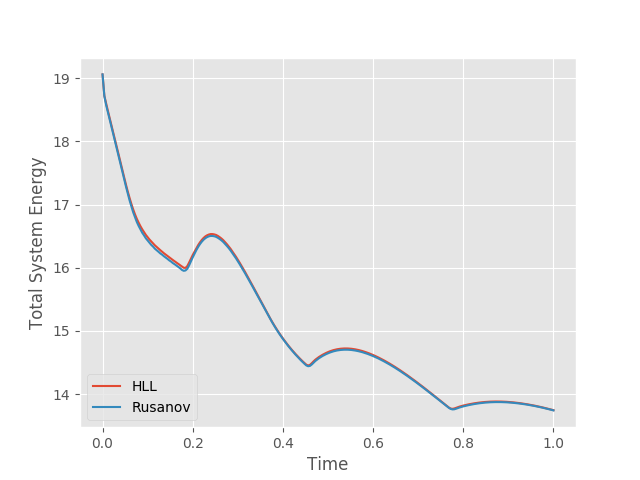

In [6]:
_, hist_hll = fvsolve2system(riemann_shallow_water_hll, initial_high_right, 
                             n=n, limit=limit_vl, args=(g,))
_, hist_rus = fvsolve2system(riemann_shallow_water_hll, initial_high_right, 
                             n=n, limit=limit_vl, args=(g,True))
hists_solvers = [hist_hll, hist_rus]
labels_solvers = ["HLL", "Rusanov"]
compare_energy(hists_solvers, labels_solvers)

The results for the HLL and Rusanov solvers appear to be similar, although the HLL solver seems to lose energy slightly more slowly.

## Overflow Error Example

Any initial condition I've tried that takes one of the supersonic branches in the approximate Riemann solver had led to an overflow error that breaks the solver. For example, below is a set of initial conditions similar to what I used above, but with a greater thickness on the right side:
\begin{align}h_0 &= \left\{\begin{matrix}
1 & x < 0.5 \\ 
6 & x \geq 0.5
\end{matrix}\right.
& v_0 &= \mathbf{0}
\end{align}

ssL 3 ssR 3
ssL 3 ssR 3
ssL 5 ssR 5
ssL 7 ssR 7
ssL 1 ssR 1
ssL 1 ssR 1
ssL 5 ssR 5
ssL 2 ssR 2
ssL 2 ssR 2
ssL 1 ssR 1
ssL 1 ssR 1
ssL 1 ssR 0
ssL 1 ssR 0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in subtract
/Users/jacob/Documents/school/class/hw4/hw_support.py:81: RuntimeWarning: invalid value encountered in subtract
  return (fluxL - fluxL[:,idxR]).flatten() / h
/Users/jacob/Documents/school/class/hw4/hw_support.py:78: RuntimeWarning: invalid value encountered in true_divide
  numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
/Users/jacob/Documents/school/class/hw4/hw_support.py:79: RuntimeWarning: invalid value encountered in multiply
  g = limit(r) * jump / (2*h)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:48: 

<IPython.core.display.Javascript object>


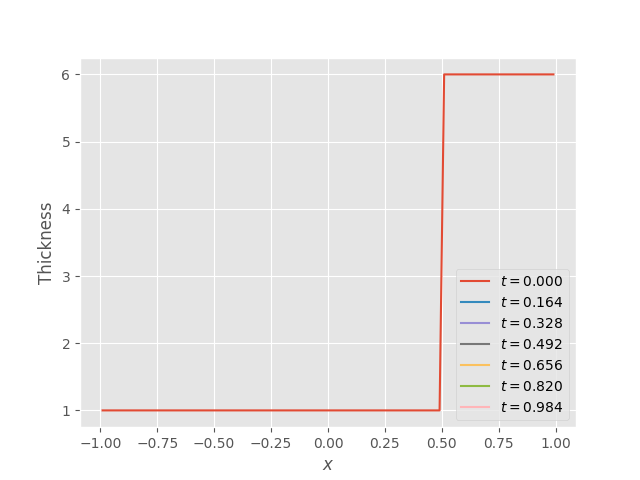

<IPython.core.display.Javascript object>


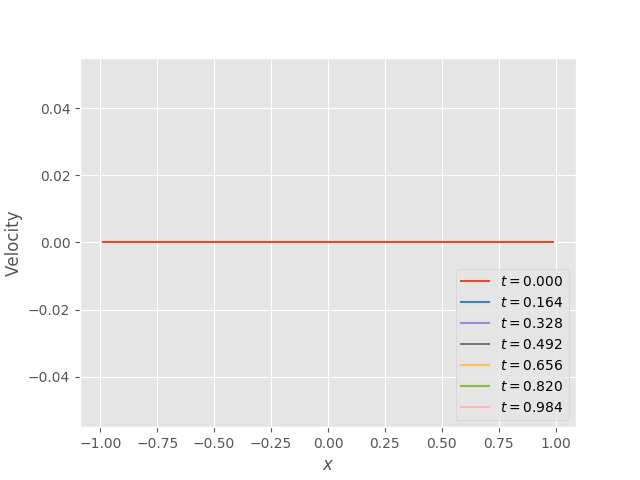

In [7]:
def initial_higher_right(x):
    return numpy.array([1 + numpy.where(x < 0.5, 0, 5),
                       0 * x])
                
plot_solution(riemann_shallow_water_hll, initial_higher_right, args=(10,))